## Imports and global variables

In [616]:
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

In [617]:
from implementations import *
from helpers import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [618]:
DATA_FOLDER = "./data/"
TRAIN_FILE = "./train.csv"
TEST_FILE = "./test.csv"
IS_DEBUG = True
NAN_VALUE = -999.0
INTEGER_COLUMN = (
    22  # 24 in raw csv file, but 23 when id and prediction column are removed
)

# For debug purpose only
SUB_SAMPLE = False

# Import dataset

In [619]:
# Load data
x_tr, y_tr = load_data(
    DATA_FOLDER + TRAIN_FILE, sub_sample=SUB_SAMPLE
)  # TODO use the provided method
x_te, y_te = load_data(DATA_FOLDER + TEST_FILE, sub_sample=SUB_SAMPLE)

print("x_tr shape : {}, y_tr shape : {}".format(x_tr.shape, y_tr.shape))
print("x_te shape : {}, y_te shape : {}".format(x_te.shape, y_te.shape))

# Define missing values as NAN
x_tr[x_tr == NAN_VALUE] = np.nan
x_te[x_te == NAN_VALUE] = np.nan

x_tr shape : (250000, 30), y_tr shape : (250000, 1)
x_te shape : (568238, 30), y_te shape : (568238, 1)


# Data exploration

## Labels

In [620]:
if not IS_DEBUG:
    nb_s = len(y_tr[y_tr == 1])
    nb_b = len(y_tr) - nb_s
    print("Signals: {} ({}%)".format(nb_s, 100 * nb_s / len(x_tr)))
    print("Backgrounds: {} ({}%)".format(nb_b, 100 * nb_b / len(x_tr)))
    print("Ratio signal / background: {}".format(nb_s / nb_b))

    plt.bar(["Signal", "Background"], [nb_s, nb_b])
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title("Labels distribution")
    plt.show()

## NAN values

In [621]:
MAX_NAN_RATIO = 0.5

nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[1]


print(
    "Nb Columns with > {:.2f} nan ratio : {}".format(
        MAX_NAN_RATIO, np.count_nonzero(nan_ratio >= MAX_NAN_RATIO)
    )
)

col_names = []
with open(DATA_FOLDER + TRAIN_FILE) as dataset:
    col_names = dataset.readline().split(",")
    nan_col_names = [
        col_name for col_idx, col_name in enumerate(col_names[2:]) if nan_ratio[col_idx]
    ]

    print("Columns with > {:.2f} nan ratio :".format(MAX_NAN_RATIO))
    print(nan_col_names)

Nb Columns with > 0.50 nan ratio : 11
Columns with > 0.50 nan ratio :
['DER_mass_MMC', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi']


## Histograms

In [622]:
if not IS_DEBUG:
    fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

    fig.suptitle("Histograms of raw features (excluding NAN values)")

    # don't select nan values
    for col_idx in range(len(col_names)-2):
        subplt = axs[col_idx%5, math.floor(col_idx/5)]

        col = x_tr[:, col_idx]
        subplt.hist(col[~np.isnan(col)], bins=100)
        subplt.set_title(col_names[col_idx+2])

    plt.tight_layout()
    plt.show()

## In depth feature analysis

In [623]:
if not IS_DEBUG:
    # select the feature to plot
    col_name_to_plot = 'DER_pt_h'
    col_idx_to_plot = get_col_idx(col_name_to_plot, col_names)

    col_to_plot = x_tr[:, col_idx_to_plot].copy()
    print(col_to_plot.shape)

    col_to_plot = np.delete(col_to_plot, (7343), axis=0)
    print(col_to_plot.shape)

    # col_to_plot = col_to_plot[~np.isnan(col_to_plot)]

    # remove potential outliers
    # col_to_plot = col_to_plot[col_to_plot < 1800]

    # plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=100)
    axs[0].set_title(col_name_to_plot)

    col_nan = col_to_plot[~np.isnan(col_to_plot)]
    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name_to_plot)

    plt.show()

    print("min: {}, max: {}".format(col_to_plot.min(), col_to_plot.max()))
    print("argmin: {}, argmax: {}".format(col_to_plot.argmin(), col_to_plot.argmax()))

    # Outlier : DER_pt_h : 7343, outlier2 = 68116
    # DER_pt_tot : 7343 again
    # PRI_met : 7343 again
    # features_to_log_transform = ['DER_pt_h', 'DER_pt_tot', 'PRI_met', 'PRI_met_sumet]

Transform the feature

In [624]:
if not IS_DEBUG:
    col_to_plot = x_tr[:, col_idx_to_plot].copy()

    # clean
    # col_to_plot = col_to_plot[~np.isnan(col_to_plot)]
    # col_to_plot = col_to_plot[col_to_plot < 1000]

    col_to_plot = np.log(col_to_plot+1)
    # col_to_plot, _,_  = standardize_training(col_to_plot)

    # plot distribution
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=100)
    axs[0].set_title(col_name_to_plot)

    col_nan = col_to_plot[~np.isnan(col_to_plot)]
    axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
    axs[1].set_title(col_name_to_plot)

    plt.show()

    print("min: {}, max: {}".format(col_to_plot.min(), col_to_plot.max()))
    print("argmin: {}, argmax: {}".format(col_to_plot.argmin(), col_to_plot.argmax()))


Test if the feature follows a power law

In [625]:
# array_cumulative=plt.hist(col_to_plot,bins=100,log=True,cumulative=-1,histtype='step')
# plt.title('Histogram of Population (cumulative)')
# plt.ylabel('# of cantons (in log scale)')
# plt.xlabel('population')
# plt.show()

# plt.loglog(array_cumulative[1][1:],array_cumulative[0])
# plt.title('Histogram of Population (cumulative)')
# plt.ylabel('# of cantons (in log scale)')
# plt.xlabel('population (in log scale)')
# plt.show()


## Problematic features analysis
Some features have been empricially defined as problematic. The problem is that after standardization, those features values will highly differ between the training and the test set, due the the presence of an outliers.
The histograms and statistics below allows us to understand which features are problematic.  
Using this technique, the sample 7343 has been identified as an outlier.

In [626]:
if not IS_DEBUG:
    fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

    fig.suptitle("Histograms of train features")

    # don't select nan values
    for col_idx in range(x_tr.shape[1]):
        subplt = axs[col_idx%5, math.floor(col_idx/5)]

        col = x_tr[:, col_idx]
        subplt.hist(col[~np.isnan(col)], bins=100)
        subplt.set_title(col_idx)

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

    fig.suptitle("Histograms of test features")

    # don't select nan values
    for col_idx in range(x_tr.shape[1]):
        subplt = axs[col_idx%5, math.floor(col_idx/5)]

        col = x_te[:, col_idx]
        subplt.hist(col[~np.isnan(col)], bins=100)
        subplt.set_title(col_idx)

    plt.tight_layout()
    plt.show()

In [627]:
if not IS_DEBUG:
    problematic_features = 'DER_mass_MMC', 'DER_mass_vis', 'DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet', 'PRI_tau_eta'

    for col_name in problematic_features:
        col_idx = get_col_idx(col_name, col_names)

        fig, axs = plt.subplots(1, 2)

        # plot train distribution
        col_tr = x_tr[:, col_idx].copy()
        col_tr = col_tr[~np.isnan(col_tr)]

        axs[0].hist(col_tr, bins=100)
        axs[0].set_title("Train {}".format(col_name))

        # plot test distribution
        col_te = x_te[:, col_idx].copy()
        col_te = col_te[~np.isnan(col_te)]

        axs[1].hist(col_te, bins=100)
        axs[1].set_title("Test {}".format(col_name))

        plt.show()

        # basic stats
        print("Train:")
        print("min: {}, max: {}".format(col_tr.min(), col_tr.max()))
        print("argmin: {}, argmax: {}".format(col_tr.argmin(), col_tr.argmax()))

        print("Test:")
        print("min: {}, max: {}".format(col_te.min(), col_te.max()))
        print("argmin: {}, argmax: {}".format(col_te.argmin(), col_te.argmax()))



# Feature engineering / Data cleaning

Remove outliers

In [628]:
# detected_outliers = [7343]


# print(x_tr.shape)

# for sample_row in detected_outliers:
#     x_tr = np.delete(x_tr, (sample_row), axis=0)
#     y_tr = np.delete(y_tr, (sample_row), axis=0)

# print(x_tr.shape)

Initial range of values

In [629]:
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

x_tr range :-18.066 4974.979
x_te range :-19.012 4794.827


### Logarithmic feature transformation

In [630]:
# TODO : transform the test features too

show_transformation = False

cols_to_log_transform = ['DER_pt_h', 'DER_pt_tot', 'PRI_met', 'PRI_met_sumet']

for col_name in cols_to_log_transform:
    col_idx = get_col_idx(col_name, col_names)
    x_tr[:, col_idx] = np.log(x_tr[:, col_idx] + 1) # +1 to avoid log(0)
    x_te[:, col_idx] = np.log(x_te[:, col_idx] + 1)

    if show_transformation:
        col_to_plot = x_tr[:, col_idx]
        #  plot distribution
        fig, axs = plt.subplots(1, 2)
        axs[0].hist(col_to_plot[~np.isnan(col_to_plot)], bins=20)
        axs[0].set_title(col_name)

        axs[1].boxplot(col_to_plot[~np.isnan(col_to_plot)])
        axs[1].set_title(col_name)

        plt.show()

### Finding degree features and handling them

In [631]:
# IDs degrees columns
# IDs_degrees = np.array([17, 20, 22, 27, 30])

# x_tr, x_te = handle_degrees(IDs_degrees,x_tr,x_te)
# Find degree features and expand them



Basic transformations
- Remove features which contains too much NAN values, because they don't contain ennough information
- Standardize training df
- Replace missing values

Before transformation:
x_tr shape : (250000, 30)
x_te shape : (568238, 30)
x_tr range :-18.066 4974.979
x_te range :-19.012 4794.827


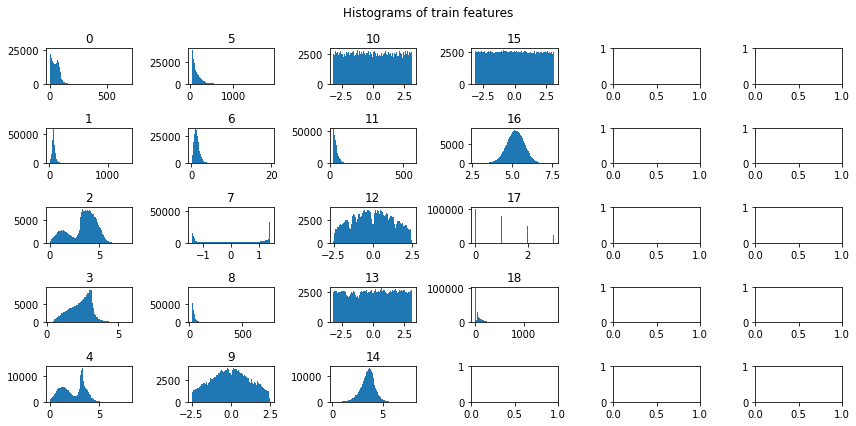

Outliers < q1 : (array([     4,     39,     49, ..., 249927, 249933, 249980], dtype=int64), array([14, 14, 14, ..., 14, 14, 14], dtype=int64)),7845
Outliers > q3 : (array([     4,     39,     49, ..., 249927, 249933, 249980], dtype=int64), array([14, 14, 14, ..., 14, 14, 14], dtype=int64)),7845
Outliers < q1 : (array([    51,     55,     80, ..., 568209, 568209, 568213], dtype=int64), array([14, 16, 16, ...,  2, 16,  2], dtype=int64)),18161
Outliers > q3 : (array([    51,     55,     80, ..., 568209, 568209, 568213], dtype=int64), array([14, 16, 16, ...,  2, 16,  2], dtype=int64)),18161


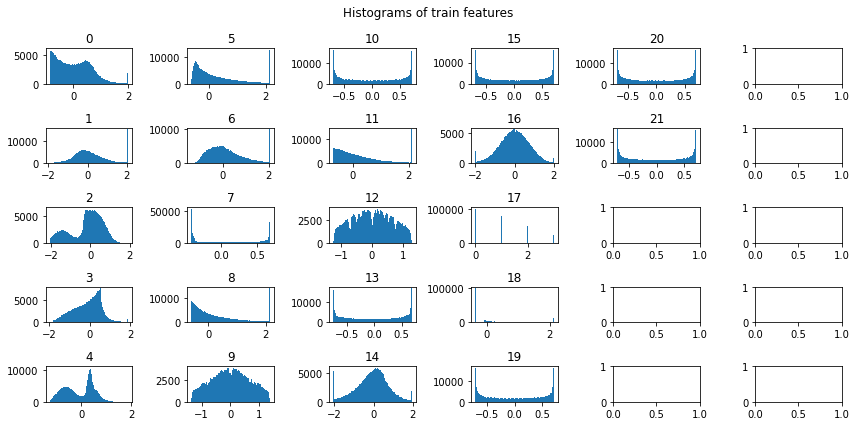

After transformation:
x_tr shape : (250000, 22)
x_te shape : (568238, 22)
x_tr range :-2.0760373982511515 3.0
x_te range :-2.0734828021024287 3.0


In [632]:
print("Before transformation:")
print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

# Remove columns with too much NAN
nb_nan = np.count_nonzero(np.isnan(x_tr), axis=0)
nan_ratio = nb_nan / x_tr.shape[1]

x_tr = x_tr[:, nan_ratio <= MAX_NAN_RATIO]
x_te = x_te[:, nan_ratio <= MAX_NAN_RATIO]
fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

fig.suptitle("Histograms of train features")

# don't select nan values
for col_idx in range(x_tr.shape[1]):
    subplt = axs[col_idx%5, math.floor(col_idx/5)]

    col = x_tr[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=100)
    subplt.set_title(col_idx)

plt.tight_layout()
plt.show()

# Standardize before replacing missing values
# _, mean_x, std_x = standardize_training(x_tr, missing_values=True) 
# TODO : update it to use the traing values
# x_te = standardize_test(x_te, mean_x, std_x)
#x_te, _, _ = standardize_training(x_te, missing_values=True)

# print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
# print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))

mean_x = np.nanmean(x_tr, axis=0)
# Replace missing data by the mean
x_tr = replace_nan_by_means(x_tr, mean_data=mean_x)
x_te = replace_nan_by_means(x_te, mean_data=mean_x)

assert(x_tr[np.isnan(x_tr)].shape[0] == 0)
assert(x_te[np.isnan(x_te)].shape[0] == 0)

IDs_degrees = np.array([10,13,15])
x_tr = transform(x_tr,IDs_degrees)
x_te = transform(x_te,IDs_degrees)

fig, axs = plt.subplots(5, 6, sharex=False, sharey=False, figsize=(12, 6))

fig.suptitle("Histograms of train features")

# don't select nan values
for col_idx in range(x_tr.shape[1]):
    subplt = axs[col_idx%5, math.floor(col_idx/5)]

    col = x_tr[:, col_idx]
    subplt.hist(col[~np.isnan(col)], bins=100)
    subplt.set_title(col_idx)

plt.tight_layout()
plt.show()
print("After transformation:")
print("x_tr shape : {}".format(x_tr.shape))
print("x_te shape : {}".format(x_te.shape))
print("x_tr range :{} {}".format(np.nanmin(x_tr), np.nanmax(x_tr)))
print("x_te range :{} {}".format(np.nanmin(x_te), np.nanmax(x_te)))
# TODO : the errors probably comes from huge values in the test set

## Analyse test set :

## Model fitting

In [633]:
# Add offset term to x
xt_tr = add_offset(x_tr)
xt_te = add_offset(x_te)

# Fit a model
w, loss_tr = least_squares(y_tr, x_tr)

print("Training loss : {}".format(loss_tr))

Training loss : 0.09596157781325892


# Model fitting and Predictions

In [634]:
# w_init = np.zeros((xt_tr.shape[1], 1))
# logistic_regression_penalized_gradient_descent_demo(y_tr, xt_tr, w_init, 10000, 0.0005, 0.5)

## Cross-validation

In [635]:
from implementations import *
from helpers import *

# w_init, _ = least_squares(y_tr, xt_tr)
# mean_loss_tr, mean_loss_te = run_cross_validation(y_tr, xt_tr, 2, w_init, 5, 2e-5,35e-5,0,2000,10,10)
# print("Mean training mse: {}".format(mean_loss_tr))
# print("Mean test mse: {}".format(mean_loss_te))

# 2000  1e-05   = 0.69310
# 722   1e-4    = 0.69307
# 444   15e-05  = 0.69285
# 222   25e-05  = 0.69265
# 222   35e-05  = 0.69242




## Predictions

### Predictions with regression and threshold

In [636]:
# # Make predictions from model's weight and set treshold for signal & background
# y_predict = x_te@w
# prediction_threshold = y_te.mean()

In [637]:
# prediction_threshold = 0
# print(y_predict.shape)
# for i in range(len(y_predict)) :
#     if y_predict[i] <= prediction_threshold :
#         y_predict[i] = 1
#     else :
#         y_predict[i] = -1
# print(y_predict.shape)
# y_test, input_test, ids_test = load_csv_data('./data/test.csv',False)
# create_csv_submission(ids_test,y_predict,"prediction test least square + feature engineering")

### Predictions with log_reg

In [681]:
# logistic_regression(y, tx, initial_w, max_iters, gamma)
# Fit the model

id = {}
y_pred = {}
for i in range(0,4):
    y_r,x_r = get_split_by_jet_data(y_tr,xt_tr,i)
    y_e,x_e = get_split_by_jet_data(y_te,xt_te,i)
    w_init = np.linalg.lstsq(x_r.T @ x_r, x_r.T @ y_r,rcond=None)[0]
    w, loss = reg_logistic_regression(y_r, x_r, 100, w_init, 1000, 50e-05)
    y_pred[i] = predict(w,x_e)
    id[i] = y_e

y_predict = np.concatenate((y_pred[0],y_pred[1],y_pred[2],y_pred[3]),axis=0)
ids_test = np.concatenate((id[0],id[1],id[2],id[3]),axis=0)


print(loss)

ok
ok
ok
ok
0.6898952732296656


In [682]:
# prediction_threshold = 0.5
# for i in range(len(y_predict)):
#     if y_predict[i] >= prediction_threshold:
#         y_predict[i] = 1
#     else:
#         y_predict[i] = -1

print(len(y_predict[y_predict == 1]))
print(len(y_predict[y_predict == -1]))
print(len(y_predict))
# 221 337
# 0.69306 -> 294338
# 0.69292 -> 228845
# 0.69292 -> 228803
# 0.69269 -> 221926
# 0.69225 -> 221928
# 0.69225 -> 221621
# 0.69225 -> 221149
# 0.69269 -> 221119



111998
456240
568238


In [683]:
#y_test, input_test, ids_test = load_csv_data("./data/test.csv", False)
create_csv_submission(
    ids_test, y_predict, "prediction test least square + feature engineering"
)